In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import log,dot,exp,shape

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from mlxtend.frequent_patterns import apriori, association_rules

from sklearn.model_selection import train_test_split  
from sklearn.datasets import make_classification

from sklearn.metrics import confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
def clustering(nbr_cluster,X):
    kmeans = KMeans(n_clusters=nbr_cluster, random_state=0).fit(X)
    labels = kmeans.labels_
    cluster_center = pd.DataFrame(kmeans.cluster_centers_.T,index=X.columns).T
    return labels, cluster_center

In [3]:
def feature_selection(X,F):
    forest = RandomForestClassifier(random_state=0)
    feature = X.drop("label",axis=1)
    classe = X["label"]

    forest.fit(feature, classe)
    importance =  forest.feature_importances_
    imp = pd.Series(importance, index=feature.columns).sort_values(ascending=False)
    return imp[0:F].index.to_list()

In [4]:
def distance_fct(feature_select_df,cluster_center_select):
    dist1 = pd.DataFrame()
    dist2 = pd.DataFrame()

    for i in feature_select_df.columns:
        dist1[i] = np.abs(feature_select_df[i] - cluster_center_select[i][0])
        dist2[i] = np.abs(feature_select_df[i] - cluster_center_select[i][1])
    return dist1,dist2

In [5]:
def impact(feature_select_df,data3):
    des = feature_select_df.describe()
    impact_df=pd.DataFrame()
    for i in feature_select_df.columns:
        impact_df[i] = pd.cut(feature_select_df[i], [-1,des[i]["mean"],des[i]["75%"],des[i]["max"]],labels = ["below_avg","avg","extreme"])
    impact_df["pred_var"] = data3["final_result"]

    impact_dummy = pd.get_dummies(impact_df)
    impact_dummy["pred_var_1"] = impact_dummy["pred_var"].map(lambda x: 1 if x==0 else 0)
    impact_dummy["pred_var_0"] = impact_dummy["pred_var"].map(lambda x: 1 if x!=0 else 0)

    impact_dummy.drop("pred_var",axis=1,inplace=True)
    return impact_dummy

In [6]:
def rule(impact_dummy):
    frq_items = apriori(impact_dummy, min_support = 0.000001, use_colnames = True)
    rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

    confidence = pd.concat((rules[rules["antecedents"]=={'pred_var_1'}],rules[rules["antecedents"]=={'pred_var_0'}])).reset_index(drop=True)
    confidence["consequents"] = confidence["consequents"].apply(lambda x: list(x))
    confidence["select"] = confidence["consequents"].map(lambda x: 1 if len(x)==1 else 0)
    confidence = confidence.drop(confidence[confidence.select==0].index, axis=0)
    return confidence

In [7]:
def lambdda_fct(impact_dummy):
    lambdda = pd.DataFrame()
    confidence = rule(impact_dummy)
    
    lambdda["classes"] = confidence["antecedents"].apply(lambda x: list(x)[-1][-1]).astype("int")
    lambdda["feature_attribute"] = confidence["consequents"].apply(lambda x: list(x)[-1]).astype("unicode")
    lambdda["impact"] = confidence["confidence"]
    lambdda["impact"] = lambdda.apply(lambda x: -1*x.impact if x.classes!=1 else x.impact,axis=1)
    lambdda.drop("classes",axis=1,inplace=True)
    lambdda_dict = lambdda[["feature_attribute","impact"]].to_dict()
    lambdda_dict = dict(zip(lambdda["feature_attribute"], lambdda["impact"]))
    return lambdda_dict

In [8]:
def distance_final(dist1,dist2,feature_select,impact_dummy):
    dist=pd.DataFrame()
    for c in feature_select:
        dist[c] = dist1[c]*impact_dummy["pred_var_1"] + dist2[c]*impact_dummy["pred_var_0"]
    return dist

In [9]:
def match1_fct(impact_dummy,lambdda_dict,feature_select,distance):
    match1=pd.DataFrame()
    consequents = list(impact_dummy.columns)[0:-2]
    for c in consequents:
        impact_dummy[c] = impact_dummy[c]*lambdda_dict[c]
    
    for c2 in feature_select:
        for c1 in impact_dummy.columns:
            if c2 in c1: 
                match1[c1] = distance[c2] * impact_dummy[c1]  
    return match1

In [10]:
def match_fct(impact_dummy,lambdda_dict,feature_select,dist):
    match=pd.DataFrame()
    match1 = match1_fct(impact_dummy,lambdda_dict,feature_select,dist)
    
    for i in feature_select: 
        liste = [ i + "_" + j for j in ["below_avg","avg","extreme"]]
        match[i] = match1.apply(lambda x: [x[l] for l in liste][np.nonzero([x[l] for l in liste])[0][0]],axis=1)
    return match



In [11]:
def penalty_fct(feature_select,match,distance):
    penalty=pd.DataFrame()
    for feature in feature_select:
        penalty[feature] = match[feature] * distance[feature]
    return(penalty.sum(axis=1))

#penalty2 = penalty_tot/penalty_tot.shape[0]
#penalty3 = penalty_tot/(F*3*penalty_tot.shape[0])

In [12]:
def penalty_final(data3,X,nbr_cluster,F):
    X["label"],cluster_center = clustering(nbr_cluster,X)
    feature_select = feature_selection(X,F)
    cluster_center_select = cluster_center[feature_select]
    
    feature_select_df = X[feature_select]
    feature_select_X = feature_select + ["label"]
    X_select = X[feature_select_X]
    dist1,dist2 = distance_fct(feature_select_df,cluster_center_select)
    
    impact_dummy = impact(feature_select_df,data3)
    lambdda_dict = lambdda_fct(impact_dummy)
    distance = distance_final(dist1,dist2,feature_select,impact_dummy)
    
    match = match_fct(impact_dummy,lambdda_dict,feature_select,distance)
    
    penalty1 = penalty_fct(feature_select,match,distance)
    return penalty1

In [13]:
from sklearn import datasets

boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = pd.Series(boston.target)
X = df.drop("target",axis=1)

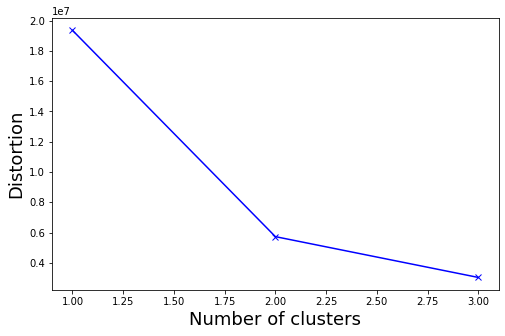

In [15]:
distortions = []
K = range(1,4)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters',fontsize=18)

plt.ylabel('Distortion',fontsize=18)
#plt.title('The Elbow Method showing the optimal number of clusters',fontsize=14)

plt.savefig('image/elbow.eps', format='eps')

plt.show()

In [16]:
X["label"],cluster_center = clustering(2,X)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


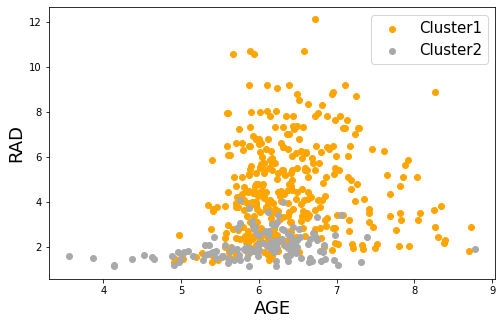

In [17]:
X_0 = X[X.label == 0].reset_index()
X_1 = X[X.label == 1].reset_index()

#filter rows of original data
plt.figure(figsize=(8,5))

dim1 = 6
dim2 = 8
#Plotting the results
plt.scatter(X_0.iloc[:,dim1] , X_0.iloc[:,dim2] , color = 'orange',label="Cluster1")
plt.scatter(X_1.iloc[:,dim1] , X_1.iloc[:,dim2] , color = 'darkgrey',label="Cluster2")

#plt.title("Data presentation")
plt.xlabel("AGE",fontsize=18);
plt.ylabel("RAD",fontsize=18);
plt.legend(fontsize=15);

plt.savefig('image/clustering_6_8.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


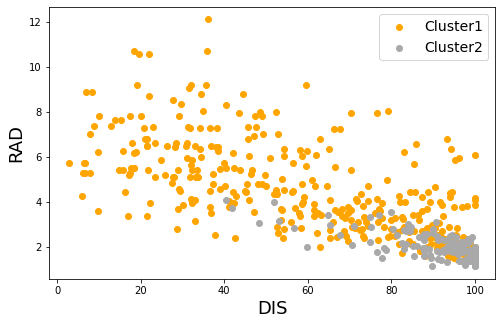

In [18]:
X_0 = X[X.label == 0].reset_index()
X_1 = X[X.label == 1].reset_index()

#filter rows of original data
plt.figure(figsize=(8,5))

dim1 = 7
dim2 = 8
#Plotting the results
plt.scatter(X_0.iloc[:,dim1] , X_0.iloc[:,dim2] , color = 'orange', label="Cluster1")
plt.scatter(X_1.iloc[:,dim1] , X_1.iloc[:,dim2] , color = 'darkgray', label="Cluster2")

#plt.title("Data presentation")
plt.xlabel("DIS",fontsize=18);
plt.ylabel("RAD",fontsize=18);
plt.legend(fontsize=14)
plt.savefig('image/clustering_7_8.eps', format='eps')


In [30]:
def impact(feature_select_df,df):
    des = feature_select_df.describe()
    impact_df=pd.DataFrame()
    
    impact_df["TAX"] = pd.cut(feature_select_df["TAX"], [-1,des["TAX"]["mean"],des["TAX"]["75%"],des["TAX"]["max"]],labels = ["below_avg","avg","extreme"])
    impact_df["RAD"] = pd.cut(feature_select_df["RAD"], [-1,des["RAD"]["50%"],des["RAD"]["mean"],des["RAD"]["max"]+1],labels = ["below_avg","avg","extreme"])
    impact_df["CRIM"] = pd.cut(feature_select_df["CRIM"], [-1,des["CRIM"]["mean"],des["CRIM"]["75%"],des["CRIM"]["max"]],labels = ["below_avg","avg","extreme"])    
    
    describe_target=df.target.describe()
    target = pd.cut(df.target, [-1,describe_target["mean"],describe_target["75%"],describe_target["max"]+1],labels = ["1","2","3"])
    impact_df["pred_var"] = target
    
    impact_df["label"] = X["label"]
    impact_dummy = pd.get_dummies(impact_df)

    impact_dummy["label_1"] = impact_dummy["label"].map(lambda x: 1 if x==1 else 0)
    impact_dummy["label_0"] = impact_dummy["label"].map(lambda x: 1 if x==0 else 0)

    impact_dummy.drop("label",axis=1,inplace=True)
    return impact_dummy

In [33]:
def rule(impact_dummy):
    frq_items = apriori(impact_dummy, min_support = 0.000001, use_colnames = True)
    rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

    confidence = pd.concat((rules[rules["antecedents"]=={'pred_var_1'}],rules[rules["antecedents"]=={'pred_var_2'}],
                           rules[rules["antecedents"]=={'pred_var_3'}])).reset_index(drop=True)
    confidence["consequents"] = confidence["consequents"].apply(lambda x: list(x))
    confidence["select"] = confidence["consequents"].map(lambda x: 1 if len(x)==1 else 0)
    confidence = confidence[confidence.select==1].reset_index(drop=True)
    return confidence

In [37]:
def lambdda_fct(impact_dummy):
    lambdda = pd.DataFrame()
    confidence = rule(impact_dummy)
    
    lambdda["classes"] = confidence["antecedents"].apply(lambda x: int(list(x)[-1][-1]))
    lambdda["feature_attribute"] = confidence["consequents"].apply(lambda x: list(x)[-1]).astype("unicode")
    lambdda["impact"] = confidence["confidence"]
    #lambdda["impact"] = lambdda.apply(lambda x: -1*x.impact if x.classes==0 else x.impact,axis=1)
    lambdda.drop("classes",axis=1,inplace=True)
    lambdda = lambdda.drop(lambdda[lambdda.feature_attribute=="label_1"].index,axis=0)
    lambdda = lambdda.drop(lambdda[lambdda.feature_attribute=="label_0"].index,axis=0)
    lambdda_dict = lambdda[["feature_attribute","impact"]].to_dict()
    lambdda_dict = dict(zip(lambdda["feature_attribute"], lambdda["impact"]))
    return lambdda_dict

In [38]:
lambdda_dict = lambdda_fct(impact_dummy)

In [40]:
def distance_final(dist1,dist2,feature_select,impact_dummy):
    dist=pd.DataFrame()
    for c in feature_select:
        dist[c] = dist1[c]*impact_dummy["label_0"] + dist2[c]*impact_dummy["label_1"]
    return dist

In [41]:
distance = distance_final(dist1,dist2,feature_select,impact_dummy)


In [44]:
def match1_fct(impact_dummy,lambdda_dict,feature_select,distance):
    match1=pd.DataFrame()
    consequents = list(impact_dummy.columns)[0:-5]
    for c in consequents:
        match1[c] = impact_dummy[c]*lambdda_dict[c]
    
    #for c2 in feature_select:
    #    for c1 in impact_dummy.columns:
    #        if c2 in c1: 
     #           match1[c1] = distance[c2] * impact_dummy[c1]  
    return match1

In [45]:
match1 = match1_fct(impact_dummy,lambdda_dict,feature_select,distance)

In [47]:
def match_fct(impact_dummy,lambdda_dict,feature_select,dist):
    match=pd.DataFrame()
    match1 = match1_fct(impact_dummy,lambdda_dict,feature_select,dist)
    
    for i in feature_select: 
        liste = [ i + "_" + j for j in ["below_avg","avg","extreme"]]
        match[i] = match1.apply(lambda x: [x[l] for l in liste][np.nonzero([x[l] for l in liste])[0][0]],axis=1)
    return match


In [48]:
match = match_fct(impact_dummy,lambdda_dict,feature_select,distance)


In [50]:
def penalty_fct(feature_select,match,distance):
    penalty=pd.DataFrame()
    for feature in feature_select:
        penalty[feature] = match[feature] * distance[feature]
    return(penalty)

In [51]:
penalty = penalty_fct(feature_select,match,distance)

In [53]:
penalty.sum(axis=1)

0      17.661278
1      66.988586
2      66.988605
3      84.798409
4      84.764392
         ...    
501    38.939701
502    38.955801
503    38.941435
504    38.896149
505    38.953816
Length: 506, dtype: float64

In [54]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,label
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,0


In [55]:
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,label
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,0.615888
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,-0.297180
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,0.650350
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,-0.025876
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,0.607449
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,-0.241692
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,0.463540
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,-0.504162
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,0.961104
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,0.938771


In [56]:
cluster_center_select

,TAX,RAD,CRIM
0,311.926829,4.455285,0.388774
1,667.642336,23.270073,12.299162


In [57]:
distance.head(4)

,TAX,RAD,CRIM
0,15.926829,3.455285,0.382454
1,69.926829,2.455285,0.361464
2,69.926829,2.455285,0.361484
3,89.926829,1.455285,0.356404


In [58]:
lambdda_dict

{'TAX_avg': 0.4747474747474747,
 'RAD_extreme': 0.3838383838383838,
 'CRIM_extreme': 0.37037037037037035,
 'TAX_extreme': 0.016835016835016835,
 'CRIM_avg': 0.0033670033670033664,
 'CRIM_below_avg': 0.9274193548387096,
 'TAX_below_avg': 0.9274193548387096,
 'RAD_below_avg': 0.7338709677419354,
 'RAD_avg': 0.1935483870967742}

In [59]:
match.head(4)

,TAX,RAD,CRIM
0,0.927419,0.733871,0.927419
1,0.927419,0.733871,0.927419
2,0.927419,0.733871,0.927419
3,0.927419,0.733871,0.927419


In [60]:
penalty.head(4)

,TAX,RAD,CRIM
0,14.770850,2.535733,0.354696
1,64.851495,1.801862,0.335229
2,64.851495,1.801862,0.335248
3,83.399882,1.067991,0.330536


In [61]:
penalty["sum"] = penalty.sum(axis=1)

In [62]:
des = penalty["sum"].describe()

In [63]:
penalty["category"] = pd.cut(penalty["sum"], [-1,des["mean"],des["75%"],des["max"]],labels = ["small","average","important"])

Text(0.5, 1.0, 'Constraints distribution in percentage')

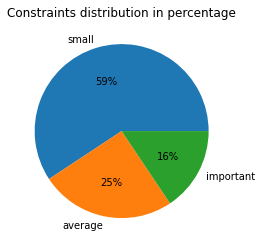

In [64]:
labels =["small","average","important"]
values = penalty["category"].value_counts()*100/X.shape[0]
data = values.values
#define Seaborn color palette to use
#create pie chart
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.title("Constraints distribution in percentage")
#plt.savefig('image/cluster_plot.eps', format='eps')

In [65]:
X["target"]=y
X["constraint"]=penalty["sum"]

In [66]:
X.corr()["constraint"].sort_values()

RAD          -0.584709
label        -0.566034
TAX          -0.532483
PTRATIO      -0.373288
CRIM         -0.311578
LSTAT        -0.258671
NOX          -0.181713
INDUS        -0.177467
AGE          -0.172925
CHAS          0.048103
DIS           0.086136
RM            0.140713
ZN            0.153907
B             0.214042
target        0.315807
constraint    1.000000
Name: constraint, dtype: float64

In [67]:
X.corr()["target"].sort_values()

LSTAT        -0.737663
PTRATIO      -0.507787
INDUS        -0.483725
TAX          -0.468536
NOX          -0.427321
label        -0.415181
CRIM         -0.388305
RAD          -0.381626
AGE          -0.376955
CHAS          0.175260
DIS           0.249929
constraint    0.315807
B             0.333461
ZN            0.360445
RM            0.695360
target        1.000000
Name: target, dtype: float64

In [68]:
penalty["category"] = pd.cut(penalty["sum"], [-200,des["mean"],des["75%"],des["max"]],labels = ["below_avg","average","important"])

In [69]:
X_select["constraint"]=penalty["sum"]

In [70]:
X_select["target"]=y

In [71]:
X_select["constraint_category"] = penalty["category"]


In [72]:
des = X_select.target.describe()
X_select["category_target"] = pd.cut(X_select["target"], [-200,des["mean"],des["75%"],des["max"]],labels = ["cheap_price","avg_price","high_price"])

In [73]:
X_select[["small-constraint","average-constraint","important-constraint"]] = pd.get_dummies(penalty["category"])
X_select[["low-price","standard-price","expensive"]] = pd.get_dummies(X_select["category_target"])

In [74]:
X_select.drop(["constraint_category","category_target"],axis=1,inplace=True)

In [75]:
X_select.corr()

,TAX,RAD,CRIM,label,constraint,target,small-constraint,average-constraint,important-constraint,low-price,standard-price,expensive
TAX,1.000000,0.910228,0.582764,0.938771,-0.532483,-0.468536,0.437231,-0.183960,-0.341429,0.403174,-0.154100,-0.327591
RAD,0.910228,1.000000,0.625505,0.961104,-0.584709,-0.381626,0.511539,-0.276910,-0.347814,0.316916,-0.148099,-0.234063
CRIM,0.582764,0.625505,1.000000,0.615888,-0.311578,-0.388305,0.304645,-0.168256,-0.204340,0.270464,-0.141539,-0.186590
label,0.938771,0.961104,0.615888,1.000000,-0.566034,-0.415181,0.504917,-0.262088,-0.352719,0.348551,-0.166718,-0.254094
constraint,-0.532483,-0.584709,-0.311578,-0.566034,1.000000,0.315807,-0.891600,0.202236,0.840979,-0.181985,-0.055485,0.256553
target,-0.468536,-0.381626,-0.388305,-0.415181,0.315807,1.000000,-0.281398,0.126700,0.212788,-0.734661,0.059612,0.789186
small-constraint,0.437231,0.511539,0.304645,0.504917,-0.891600,-0.281398,1.000000,-0.519071,-0.698569,0.146344,0.081826,-0.238647
average-constraint,-0.183960,-0.276910,-0.168256,-0.262088,0.202236,0.126700,-0.519071,1.000000,-0.248990,-0.103607,0.010621,0.109373
important-constraint,-0.341429,-0.347814,-0.204340,-0.352719,0.840979,0.212788,-0.698569,-0.248990,1.000000,-0.079088,-0.101609,0.178852
low-price,0.403174,0.316916,0.270464,0.348551,-0.181985,-0.734661,0.146344,-0.103607,-0.079088,1.000000,-0.535641,-0.679179


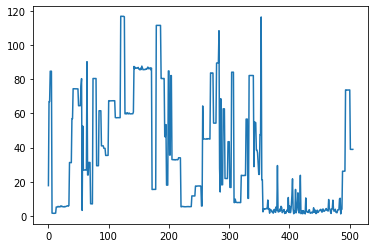

In [76]:
plt.plot(X["constraint"])

(array([201.,  51.,  48.,  32.,  26.,  41.,  33.,  57.,   0.,  17.]),
 array([  1.07911383,  12.67426008,  24.26940634,  35.86455259,
         47.45969885,  59.0548451 ,  70.64999136,  82.24513761,
         93.84028387, 105.43543013, 117.03057638]),
 <BarContainer object of 10 artists>)

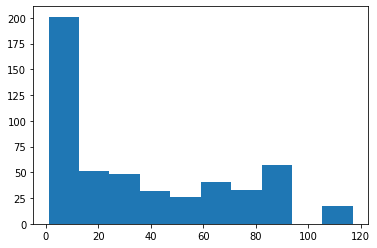

In [77]:
plt.hist(X["constraint"])

In [78]:
X["distance_tax"]=distance["TAX"]
X["distance_rad"]=distance["RAD"]
X["distance_crim"]=distance["CRIM"]


In [79]:
X.corr()["label"].sort_values()

constraint      -0.566034
distance_tax    -0.557985
DIS             -0.504162
B               -0.438496
target          -0.415181
ZN              -0.297180
RM              -0.241692
CHAS            -0.025876
distance_rad     0.033765
AGE              0.463540
PTRATIO          0.490436
LSTAT            0.514299
distance_crim    0.519852
NOX              0.607449
CRIM             0.615888
INDUS            0.650350
TAX              0.938771
RAD              0.961104
label            1.000000
Name: label, dtype: float64

In [80]:
X.head(5)["constraint"]

0    17.661278
1    66.988586
2    66.988605
3    84.798409
4    84.764392
Name: constraint, dtype: float64

In [81]:
test = X.head(50).drop_duplicates(["TAX","RAD"]).reset_index()

In [82]:
test = test.append(X.iloc[[172,353]])


In [83]:
test = test.reset_index()

In [84]:
X.iloc[[172,353]]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,label,target,constraint,distance_tax,distance_rad,distance_crim
172,0.13914,0.0,4.05,0.0,0.51,5.572,88.5,2.5961,5.0,296.0,16.6,396.90,14.69,0,23.1,15.402116,15.926829,0.544715,0.249634
353,0.01709,90.0,2.02,0.0,0.41,6.728,36.1,12.1265,5.0,187.0,17.0,384.46,4.50,0,30.1,116.604018,124.926829,0.544715,0.371684


In [85]:
penalty.iloc[[172,353]]

,TAX,RAD,CRIM,sum,category
172,14.770850,0.399751,0.231516,15.402116,below_avg
353,115.859559,0.399751,0.344707,116.604018,important


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


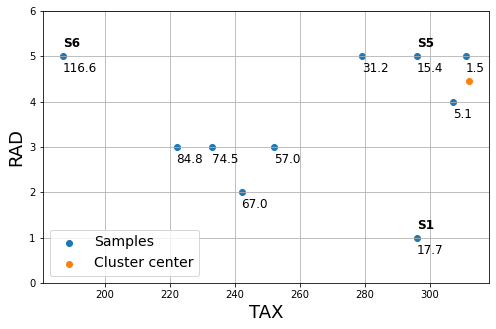

In [86]:
import numpy
from matplotlib import pyplot
fig = plt.figure(figsize=(8,5))

x = test["TAX"]
y = test["RAD"]
c = np.round(test["constraint"],1)

ax = fig.add_subplot(111)
pyplot.scatter(x,y,label="Samples")
ax.set_ylim(0,6)
index=-1
for i,j in zip(x,y):
    
    index+=1
    ax.annotate(str(c[index]),xy=(i,j-0.35),fontsize=12)

ax.annotate("S1",xy=(296,1+0.2),weight='bold',fontsize=12)
ax.annotate("S5",xy=(296,5+0.2),weight='bold',fontsize=12)
ax.annotate("S6",xy=(187,5+0.2),weight='bold',fontsize=12)    
    
plt.scatter(cluster_center["TAX"][0],cluster_center["RAD"][0],label="Cluster center")
plt.grid() 

ax.legend(fontsize=14)
#plt.title("Data distribution",fontsize=12);
plt.ylabel("RAD",fontsize=18)
plt.xlabel("TAX",fontsize=18)

plt.savefig('image/distribution_constraints.eps', format='eps')

pyplot.show()

# Ablation

In [87]:
def penalty_fct2(feature_select,match,distance):
    penalty=pd.DataFrame()
    for feature in feature_select:
        penalty[feature] = match[feature] #* distance[feature]
    return(penalty)

In [88]:
penalty2 = penalty_fct2(feature_select,match,distance)

In [89]:
penalty2["constraint"] = penalty2.sum(axis=1)

In [90]:
penalty2

,TAX,RAD,CRIM,constraint
0,0.927419,0.733871,0.927419,2.58871
1,0.927419,0.733871,0.927419,2.58871
2,0.927419,0.733871,0.927419,2.58871
3,0.927419,0.733871,0.927419,2.58871
4,0.927419,0.733871,0.927419,2.58871
...,...,...,...,...
501,0.927419,0.733871,0.927419,2.58871
502,0.927419,0.733871,0.927419,2.58871
503,0.927419,0.733871,0.927419,2.58871
504,0.927419,0.733871,0.927419,2.58871


In [91]:
def penalty_fct3(feature_select,match,distance):
    penalty=pd.DataFrame()
    for feature in feature_select:
        penalty[feature] = distance[feature]#match[feature] * distance[feature]
    return(penalty)

In [92]:
penalty3 = penalty_fct3(feature_select,match,distance)

In [93]:
penalty3["constraint"] = penalty3.sum(axis=1)

In [94]:
penalty3

,TAX,RAD,CRIM,constraint
0,15.926829,3.455285,0.382454,19.764568
1,69.926829,2.455285,0.361464,72.743578
2,69.926829,2.455285,0.361484,72.743598
3,89.926829,1.455285,0.356404,91.738518
4,89.926829,1.455285,0.319724,91.701838
...,...,...,...,...
501,38.926829,3.455285,0.326144,42.708258
502,38.926829,3.455285,0.343504,42.725618
503,38.926829,3.455285,0.328014,42.710128
504,38.926829,3.455285,0.279184,42.661298


In [95]:
penalty3_1 = penalty3.iloc[[0,1,3,6,13,35,39,41,172,353]].reset_index(drop=True)

In [96]:
penalty2_1 = penalty2.iloc[[0,1,3,6,13,35,39,41,172,353]].reset_index(drop=True)

In [97]:
penalty2_1

,TAX,RAD,CRIM,constraint
0,0.927419,0.733871,0.927419,2.58871
1,0.927419,0.733871,0.927419,2.58871
2,0.927419,0.733871,0.927419,2.58871
3,0.927419,0.733871,0.927419,2.58871
4,0.927419,0.733871,0.927419,2.58871
5,0.927419,0.733871,0.927419,2.58871
6,0.927419,0.733871,0.927419,2.58871
7,0.927419,0.733871,0.927419,2.58871
8,0.927419,0.733871,0.927419,2.58871
9,0.927419,0.733871,0.927419,2.58871


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


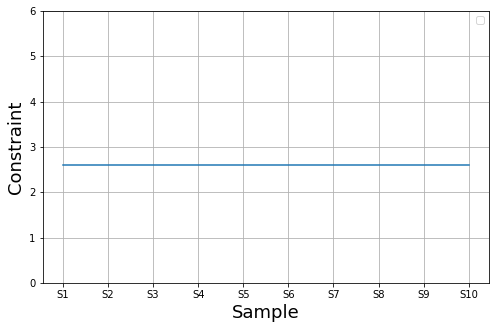

In [143]:
import numpy
from matplotlib import pyplot
fig = plt.figure(figsize=(8,5))

#x = penalty2_1["TAX"]
#y = penalty2_1["RAD"]
#c = np.round(penalty3_1["constraint"],1)

x =["S1","S2","S3","S4","S5","S6","S7","S8","S9","S10"]
y = np.round(penalty2_1["constraint"],1)

ax = fig.add_subplot(111)
pyplot.plot(x,y)
ax.set_ylim(0,6)
index=-1

plt.grid() 

ax.legend()
#plt.title("Constraints distribution",fontsize=12);
plt.ylabel("Constraint",fontsize=18)
plt.xlabel("Sample",fontsize=18)

plt.savefig('image/ablation_behavior.eps', format='eps')

pyplot.show()

In [99]:
test2 = X.iloc[[0,1,3,6,13,35,39,41,172,353]]
test2=test2[["TAX","CRIM","RAD"]]
test2["constraint"]=penalty2["constraint"].iloc[[0,1,3,6,13,35,39,41,172,353]]
test2 = test2.reset_index(drop=True)

In [100]:
test2

,TAX,CRIM,RAD,constraint
0,296.0,0.00632,1.0,2.58871
1,242.0,0.02731,2.0,2.58871
2,222.0,0.03237,3.0,2.58871
3,311.0,0.08829,5.0,2.58871
4,307.0,0.62976,4.0,2.58871
5,279.0,0.06417,5.0,2.58871
6,252.0,0.02763,3.0,2.58871
7,233.0,0.12744,3.0,2.58871
8,296.0,0.13914,5.0,2.58871
9,187.0,0.01709,5.0,2.58871


In [113]:
test3 = X.iloc[[0,1,3,6,13,35,39,41,172,353]]

test3=test3[["TAX","CRIM","RAD"]]
test3["constraint"]=penalty3["constraint"].iloc[[0,1,3,6,13,35,39,41,172,353]]
test3["constraint_TAX"]=penalty3["TAX"].iloc[[0,1,3,6,13,35,39,41,172,353]]
test3["constraint_RAD"]=penalty3["RAD"].iloc[[0,1,3,6,13,35,39,41,172,353]]
test3["output"] = X["target"].iloc[[0,1,3,6,13,35,39,41,172,353]]
test3 = test3.reset_index(drop=True)

In [115]:
test3.corr()

,TAX,CRIM,RAD,constraint,constraint_TAX,constraint_RAD,output
TAX,1.000000,0.444482,0.082151,-0.999694,-1.000000,-0.050440,-0.698459
CRIM,0.444482,1.000000,0.213283,-0.454189,-0.444482,-0.404668,-0.408781
RAD,0.082151,0.213283,1.000000,-0.105484,-0.082151,-0.953277,-0.164830
constraint,-0.999694,-0.454189,-0.105484,1.000000,0.999694,0.075108,0.699756
constraint_TAX,-1.000000,-0.444482,-0.082151,0.999694,1.000000,0.050440,0.698459
constraint_RAD,-0.050440,-0.404668,-0.953277,0.075108,0.050440,1.000000,0.092575
output,-0.698459,-0.408781,-0.164830,0.699756,0.698459,0.092575,1.000000


In [122]:
X["constraint_3"] = penalty3["constraint"]
X.corr()["target"]

CRIM            -0.388305
ZN               0.360445
INDUS           -0.483725
CHAS             0.175260
NOX             -0.427321
RM               0.695360
AGE             -0.376955
DIS              0.249929
RAD             -0.381626
TAX             -0.468536
PTRATIO         -0.507787
B                0.333461
LSTAT           -0.737663
label           -0.415181
target           1.000000
constraint       0.315807
distance_tax     0.242034
distance_rad     0.012207
distance_crim   -0.290481
constraint_3     0.203849
Name: target, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


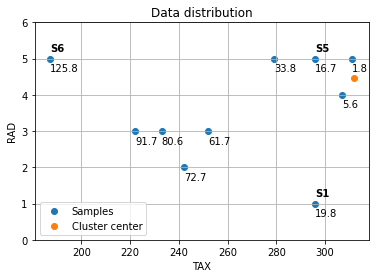

In [161]:
import numpy
from matplotlib import pyplot
fig = plt.figure(figsize=(6,4))

x = test3["TAX"]
y = test3["RAD"]
c = np.round(test3["constraint"],1)

ax = fig.add_subplot(111)
pyplot.scatter(x,y,label="Samples")
ax.set_ylim(0,6)
index=-1
for i,j in zip(x,y):
    
    index+=1
    ax.annotate(str(c[index]),xy=(i,j-0.35))

ax.annotate("S1",xy=(296,1+0.2),weight='bold')
ax.annotate("S5",xy=(296,5+0.2),weight='bold')
ax.annotate("S6",xy=(187,5+0.2),weight='bold')    
    
plt.scatter(cluster_center["TAX"][0],cluster_center["RAD"][0],label="Cluster center")
plt.grid() 

ax.legend()
plt.title("Data distribution",fontsize=12);
plt.ylabel("RAD")
plt.xlabel("TAX")

#plt.savefig('image/distribution_constraints.eps', format='eps')

pyplot.show()

In [167]:
test3_distance = distance.iloc[[0,1,3,6,13,35,39,41,172,353]][["TAX","CRIM","RAD"]].reset_index(drop=True)
test3_distance["sum"]=test3_distance.sum(axis=1)

In [168]:
test3_distance

,TAX,CRIM,RAD,sum
0,15.926829,0.382454,3.455285,19.764568
1,69.926829,0.361464,2.455285,72.743578
2,89.926829,0.356404,1.455285,91.738518
3,0.926829,0.300484,0.544715,1.772029
4,4.926829,0.240986,0.455285,5.623099
5,32.926829,0.324604,0.544715,33.796149
6,59.926829,0.361144,1.455285,61.743258
7,78.926829,0.261334,1.455285,80.643448
8,15.926829,0.249634,0.544715,16.721179
9,124.926829,0.371684,0.544715,125.843229


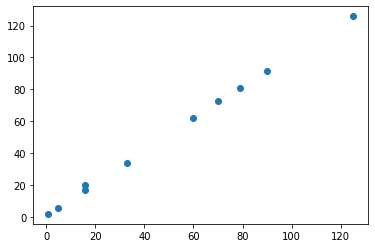

In [170]:
plt.scatter(test3_distance["TAX"],test3_distance["sum"])

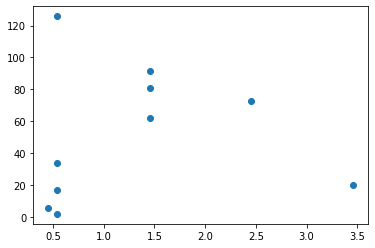

In [171]:
plt.scatter(test3_distance["RAD"],test3_distance["sum"])

In [150]:
f = X.iloc[[0,1,3,6,13,35,39,41,172,353]][["TAX","CRIM","RAD","distance_tax","distance_rad","distance_crim"]].reset_index(drop=True)

In [151]:
f["constraint"]=

,TAX,CRIM,RAD,distance_tax,distance_rad,distance_crim
0,296.0,0.00632,1.0,15.926829,3.455285,0.382454
1,242.0,0.02731,2.0,69.926829,2.455285,0.361464
2,222.0,0.03237,3.0,89.926829,1.455285,0.356404
3,311.0,0.08829,5.0,0.926829,0.544715,0.300484
4,307.0,0.62976,4.0,4.926829,0.455285,0.240986
5,279.0,0.06417,5.0,32.926829,0.544715,0.324604
6,252.0,0.02763,3.0,59.926829,1.455285,0.361144
7,233.0,0.12744,3.0,78.926829,1.455285,0.261334
8,296.0,0.13914,5.0,15.926829,0.544715,0.249634
9,187.0,0.01709,5.0,124.926829,0.544715,0.371684


In [145]:
cluster_center[["TAX","RAD","CRIM"]]

,TAX,RAD,CRIM
0,311.926829,4.455285,0.388774
1,667.642336,23.270073,12.299162


In [139]:
X.iloc[[0,1,3,6,13,35,39,41,172,353]][["TAX","RAD","CRIM","label"]]

,TAX,RAD,CRIM,label
0,296.0,1.0,0.00632,0
1,242.0,2.0,0.02731,0
3,222.0,3.0,0.03237,0
6,311.0,5.0,0.08829,0
13,307.0,4.0,0.62976,0
35,279.0,5.0,0.06417,0
39,252.0,3.0,0.02763,0
41,233.0,3.0,0.12744,0
172,296.0,5.0,0.13914,0
353,187.0,5.0,0.01709,0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


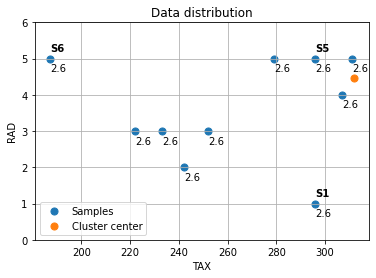

In [164]:
import numpy
from matplotlib import pyplot
fig = plt.figure(figsize=(6,4))

x = test2["TAX"]
y = test2["RAD"]
c = np.round(test2["constraint"],1)

ax = fig.add_subplot(111)
pyplot.scatter(x,y,label="Samples",s=50)
ax.set_ylim(0,6)
index=-1
for i,j in zip(x,y):
    
    index+=1
    ax.annotate(str(c[index]),xy=(i,j-0.35))

ax.annotate("S1",xy=(296,1+0.2),weight='bold')
ax.annotate("S5",xy=(296,5+0.2),weight='bold')
ax.annotate("S6",xy=(187,5+0.2),weight='bold')    
    
plt.scatter(cluster_center["TAX"][0],cluster_center["RAD"][0],label="Cluster center",s=50)
plt.grid() 

ax.legend()
plt.title("Data distribution",fontsize=12);
plt.ylabel("RAD")
plt.xlabel("TAX")

plt.savefig('image/distribution_constraints.eps', format='eps')

pyplot.show()

In [149]:
X = X.rename(columns={"target":"output_variable","distance_tax":"behavior_tax","distance_rad":"behavior_rad","distance_crim":"behavior_crim","constraint_3":"behavior"})

In [157]:
X.to_csv("learning_constraints.csv",index=False)

In [85]:
test[["TAX","CRIM","RAD","distance_tax","distance_rad","distance_crim","constraint"]]

,TAX,CRIM,RAD,distance_tax,distance_rad,distance_crim,constraint
0,296.0,0.00632,1.0,15.926829,3.455285,0.382454,17.661278
1,242.0,0.02731,2.0,69.926829,2.455285,0.361464,66.988586
2,222.0,0.03237,3.0,89.926829,1.455285,0.356404,84.798409
3,311.0,0.08829,5.0,0.926829,0.544715,0.300484,1.537985
4,307.0,0.62976,4.0,4.926829,0.455285,0.240986,5.126852
5,279.0,0.06417,5.0,32.926829,0.544715,0.324604,31.237774
6,252.0,0.02763,3.0,59.926829,1.455285,0.361144,56.980225
7,233.0,0.12744,3.0,78.926829,1.455285,0.261334,74.508627
8,296.0,0.13914,5.0,15.926829,0.544715,0.249634,15.402116
9,187.0,0.01709,5.0,124.926829,0.544715,0.371684,116.604018


In [98]:
test

,level_0,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,...,TAX,PTRATIO,B,LSTAT,label,target,constraint,distance_tax,distance_rad,distance_crim
0,0,0.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,...,296.0,15.3,396.90,4.98,0,24.0,17.661278,15.926829,3.455285,0.382454
1,1,1.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,...,242.0,17.8,396.90,9.14,0,21.6,66.988586,69.926829,2.455285,0.361464
2,2,3.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,...,222.0,18.7,394.63,2.94,0,33.4,84.798409,89.926829,1.455285,0.356404
3,3,6.0,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,...,311.0,15.2,395.60,12.43,0,22.9,1.537985,0.926829,0.544715,0.300484
4,4,13.0,0.62976,0.0,8.14,0.0,0.538,5.949,61.8,4.7075,...,307.0,21.0,396.90,8.26,0,20.4,5.126852,4.926829,0.455285,0.240986
5,5,35.0,0.06417,0.0,5.96,0.0,0.499,5.933,68.2,3.3603,...,279.0,19.2,396.90,9.68,0,18.9,31.237774,32.926829,0.544715,0.324604
6,6,39.0,0.02763,75.0,2.95,0.0,0.428,6.595,21.8,5.4011,...,252.0,18.3,395.63,4.32,0,30.8,56.980225,59.926829,1.455285,0.361144
7,7,41.0,0.12744,0.0,6.91,0.0,0.448,6.770,2.9,5.7209,...,233.0,17.9,385.41,4.84,0,26.6,74.508627,78.926829,1.455285,0.261334
8,172,NaN,0.13914,0.0,4.05,0.0,0.510,5.572,88.5,2.5961,...,296.0,16.6,396.90,14.69,0,23.1,15.402116,15.926829,0.544715,0.249634
9,353,NaN,0.01709,90.0,2.02,0.0,0.410,6.728,36.1,12.1265,...,187.0,17.0,384.46,4.50,0,30.1,116.604018,124.926829,0.544715,0.371684


In [150]:
X_sorted = X.sort_values(by=['target'])

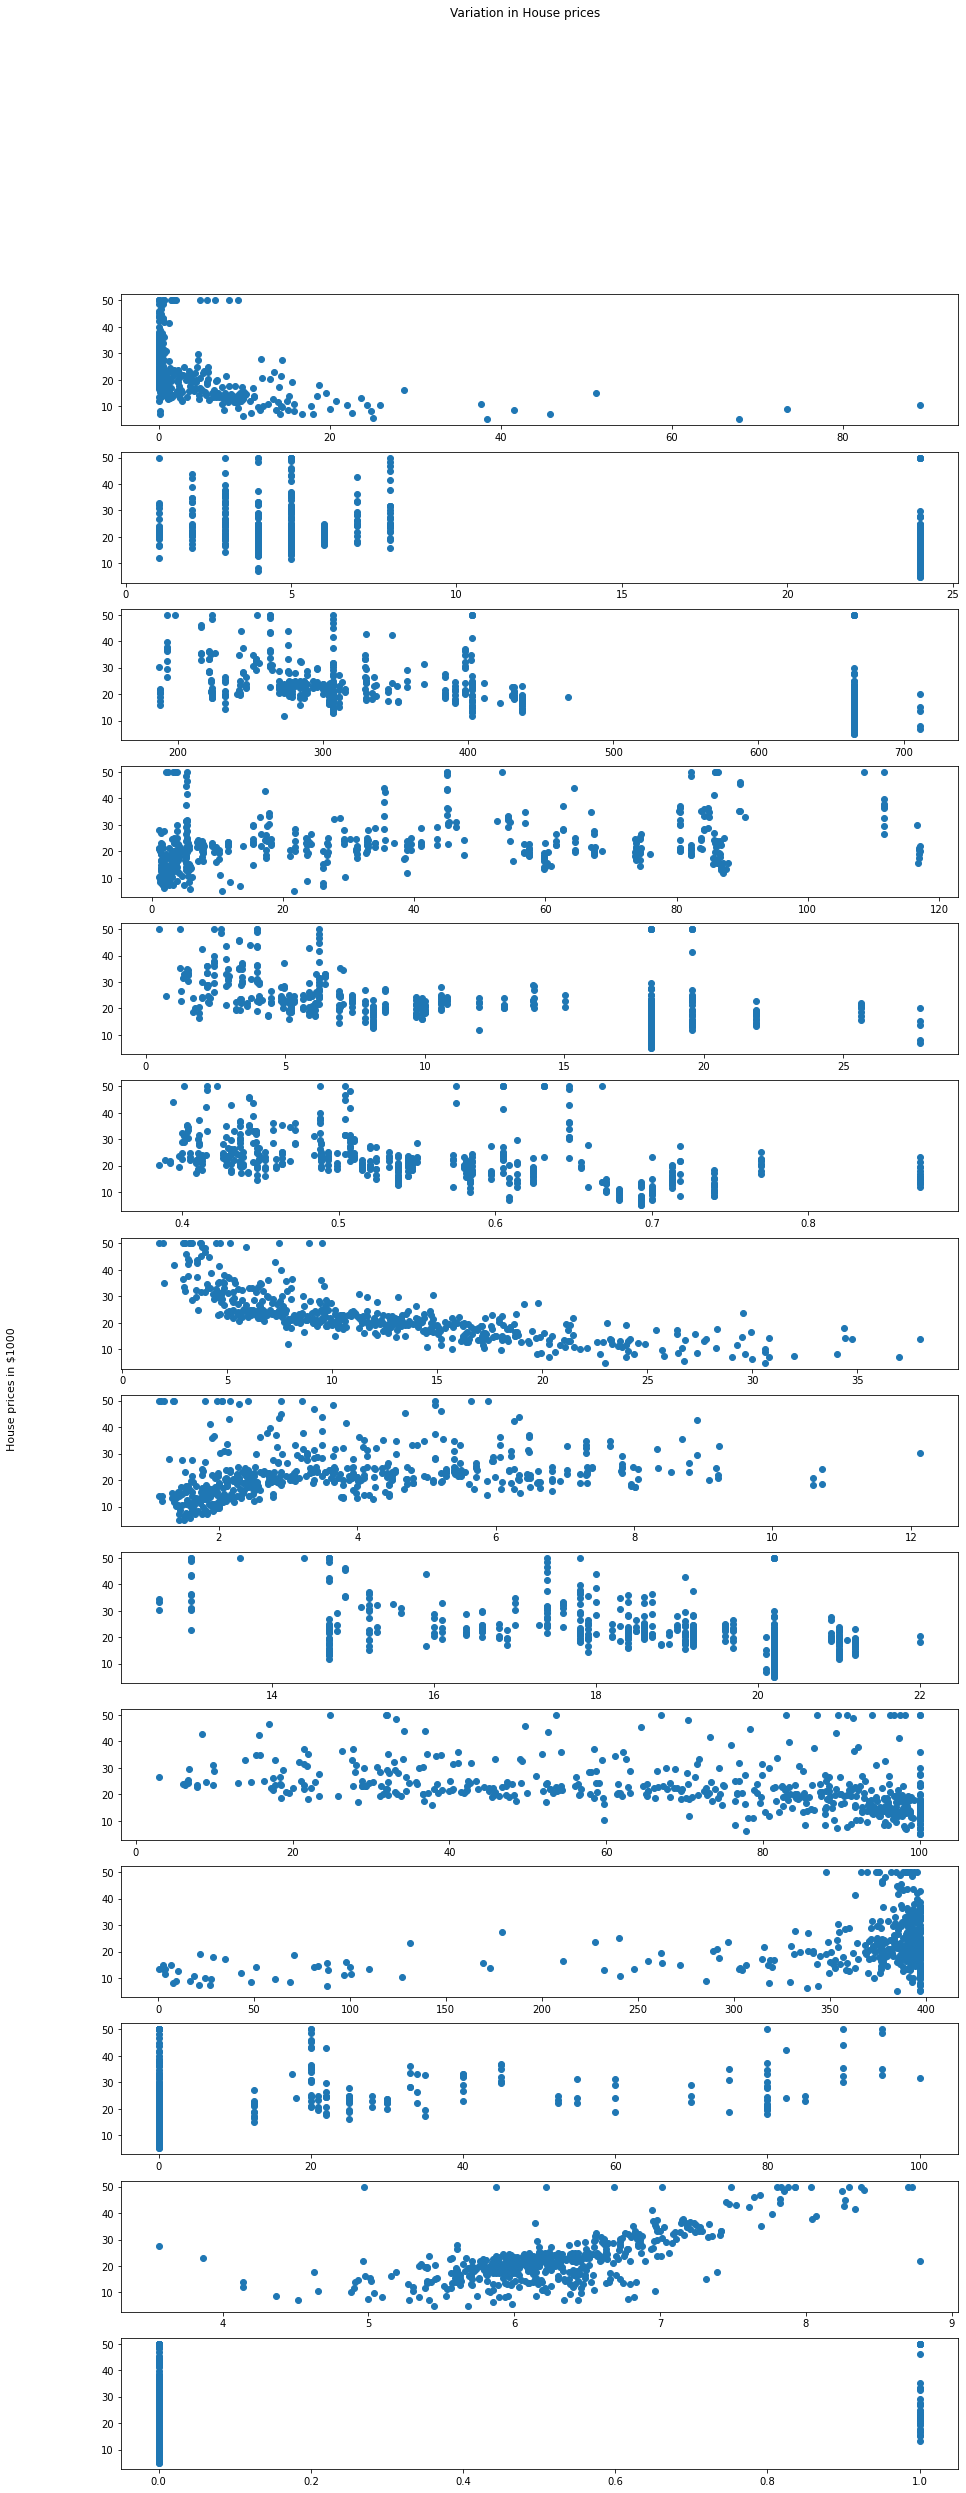

In [154]:
fig = plt.figure(figsize=(15,40))

features = ['CRIM', 'RAD', 'TAX','constraint', 'INDUS','NOX','LSTAT','DIS','PTRATIO','AGE','B','ZN','RM','CHAS']
target = X_sorted['target']

plt.suptitle("Variation in House prices",fontsize=12);
fig.supylabel('House prices in $1000',fontsize=11)
for i, col in enumerate(features):
    plt.subplot(len(features),1 , i+1)
    x= X_sorted[col]
    y= target
    plt.scatter(x,y, marker='o')

#plt.savefig('image/viz.eps', format='eps')


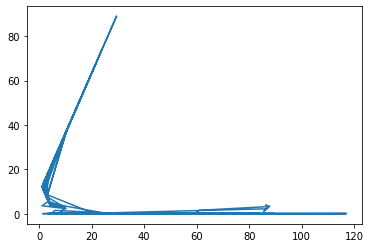

In [115]:
plt.plot(X["constraint"],X["CRIM"])

In [391]:
X_select.corr()[["low-price","standard-price","expensive","target","label"]].head(9)

,low-price,standard-price,expensive,target,label
TAX,0.403174,-0.154100,-0.327591,-0.468536,0.938771
RAD,0.316916,-0.148099,-0.234063,-0.381626,0.961104
CRIM,0.270464,-0.141539,-0.186590,-0.388305,0.615888
label,0.348551,-0.166718,-0.254094,-0.415181,1.000000
constraint,-0.181985,-0.055485,0.256553,0.315807,-0.566034
target,-0.734661,0.059612,0.789186,1.000000,-0.415181
small-constraint,0.146344,0.081826,-0.238647,-0.281398,0.504917
average-constraint,-0.103607,0.010621,0.109373,0.126700,-0.262088
important-constraint,-0.079088,-0.101609,0.178852,0.212788,-0.352719


In [173]:
X_cheap = X_select[X_select["category_target"]=="cheap_price"]
X_average = X_select[X_select["category_target"]=="avg_price"]
X_high = X_select[X_select["category_target"]=="high_price"]

-------------------------------------------------------------------------------------------------------

In [46]:
class LogisticRegression:
    
    
    def sigmoid(self,z):
        sig = 1/(1+exp(-z))
        return sig
    
    def initialize(self,X):
        weights = np.zeros((shape(X)[1]+1,1))
        X = np.c_[np.ones((shape(X)[0],1)),X]
        return weights,X
    
    
    def fit(self,X,y,p,trade_off,alpha=0.001,iter=400):
        weights,X = self.initialize(X)
        
        def cost(theta):
            z = dot(X,theta)
            cost0 = y.T.dot(log(self.sigmoid(z)))
            cost1 = (1-y).T.dot(log(1-self.sigmoid(z)))  
            cost = -((cost1 + cost0))/len(y) 
            return cost1
    
        
        cost_list = np.zeros(iter,)

        for i in range(iter):
            weights = weights - alpha*dot(X.T,self.sigmoid(dot(X,weights)+ np.reshape(np.array(p)*trade_off,(len(np.array(p)),1)))
                                          -np.reshape(y,(len(y),1)))
            cost_list[i] = cost(weights) 
        self.weights = weights 
        
        return cost_list
    
    
    def predict(self,X,p,trade_off):
        zi = dot(self.initialize(X)[1],self.weights)
        z = dot(self.initialize(X)[1],self.weights) + np.reshape(np.array(p)*trade_off,(len(np.array(p)),1))
        
     
        lis = []
        for i in self.sigmoid(z):
            if i>0.5:
                lis.append(1)
            else:
                lis.append(0)
        return lis


---------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
class3 = pd.read_csv("data/class3.csv")
result = pd.read_csv("data/studentInfo.csv")

data3 = class3.merge(result,on=["code_module","code_presentation","id_student"])
data3.dropna(inplace=True)

In [43]:
le = LabelEncoder()
data3["code_module"] = le.fit_transform(data3["code_module"])
data3["code_presentation"] = le.fit_transform(data3["code_presentation"])
data3["gender"] = le.fit_transform(data3["gender"])
data3["region"] = le.fit_transform(data3["region"])
data3["highest_education"] = le.fit_transform(data3["highest_education"])
data3["imd_band"] = le.fit_transform(data3["imd_band"])
data3["age_band"] = le.fit_transform(data3["age_band"])
data3["disability"] = le.fit_transform(data3["disability"])
data3["final_result"] = le.fit_transform(data3["final_result"])

In [44]:
features = [ 'log_active_coll_asyn', 'log_active_coll_syn', 'log_active_feedback',
       'log_reflective_individual', 'log_reflective_evaluation',
       'log_verbal_coll_syn', 'log_verbal_individual', 'log_sensing_coll_asyn',
       'log_sensing_evaluation', 'log_sensing_individual',
       'log_global_individual',
       'sum_active_coll_syn', 'sum_active_feedback',
       'sum_reflective_individual', 
       'ClickRate_active_coll_syn_vs_max', 'ClickRate_active_feedback_vs_max',
       'ClickRate_reflective_individual_vs_max',
       'ClickRate_sensing_evaluation_vs_max',
       'ClickRate_global_individual_vs_max',
       'ClickRate_sequential_individual_vs_max',
       'ClickRate_verbal_individual_vs_max',
       'ClickRate_verbal_coll_syn_vs_max',
       'ClickRate_visual_individual_vs_max', 
        #'score', 
        'vs_max_score','submitted_vs_deadline', 'ClickRate_active_coll_asyn_vs_pass',
       'ClickRate_reflective_individual_vs_pass','ClickRate_global_individual_vs_pass',
       'ClickRate_reflective_evaluation_vs_pass',
       'ClickRate_sensing_coll_asyn_vs_pass', 'ClickRate_vs_pass']

In [45]:
X = np.data3[features]

--------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
penalty1 = penalty_final(data3,X,nbr_cluster=2,F=5)

In [21]:
data3["final_result"] = data3["final_result"].map(lambda x: 1 if x==0 else 2)
y = np.array(data3["final_result"])
X_array = np.array(X)

-------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
results=pd.DataFrame()

for trade_off_i in range(0,1000,100):
    obj1 = LogisticRegression()
    model= obj1.fit(X_array,y,penalty1,trade_off_i)
    y_pred = obj1.predict(X,penalty1,trade_off_i)
    y_pred = [1 if i==0 else 2 for i in y_pred]
    
    cm = confusion_matrix(y,y_pred)
    sen= cm[1,1] /(cm[1,1] + cm[1,0])
    spe=cm[0,0] /(cm[0,0]+ cm[0,1])
    
    results = results.append({"trade off":trade_off_i,"confusion matrix":confusion_matrix(y,y_pred), "accuracy score":accuracy_score(y,y_pred),
                    "sensitivity":sen,"specificity":spe,"balanced accuracy":(sen+spe)/2},ignore_index = True)


In [356]:
results.to_csv("data/results.csv",index=False)

In [2]:
results = pd.read_csv("data/results.csv")

In [4]:
results

,trade off,confusion matrix,accuracy score,sensitivity,specificity,balanced accuracy
0,10000.0,[[ 416 2409]\n [ 83 21852]],0.899354,0.996216,0.147257,0.571736
1,10050.0,[[ 419 2406]\n [ 83 21852]],0.899475,0.996216,0.148319,0.572267
2,10100.0,[[ 420 2405]\n [ 83 21852]],0.899515,0.996216,0.148673,0.572444
3,10150.0,[[ 423 2402]\n [ 85 21850]],0.899556,0.996125,0.149735,0.572930
4,10200.0,[[ 425 2400]\n [ 85 21850]],0.899637,0.996125,0.150442,0.573284
...,...,...,...,...,...,...
795,49750.0,[[ 1028 1797]\n [ 1108 20827]],0.882674,0.949487,0.363894,0.656690
796,49800.0,[[ 1028 1797]\n [ 1108 20827]],0.882674,0.949487,0.363894,0.656690
797,49850.0,[[ 1029 1796]\n [ 1111 20824]],0.882593,0.949350,0.364248,0.656799
798,49900.0,[[ 1029 1796]\n [ 1111 20824]],0.882593,0.949350,0.364248,0.656799


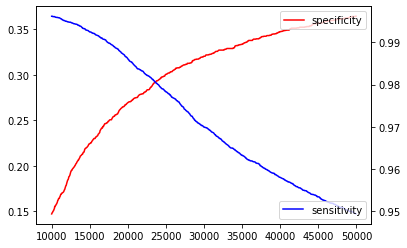

In [3]:
fig, ax = plt.subplots()
plt.plot(results["trade off"],results.specificity, 'r', label='specificity')
plt.legend(loc="upper right")

ax2 = ax.twinx()
plt.plot(results["trade off"],results.sensitivity, 'b', label='sensitivity')
plt.legend(loc="lower right")


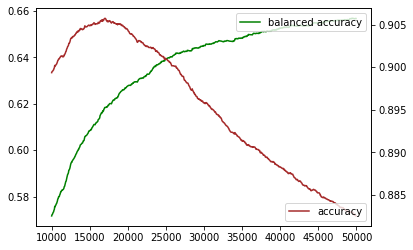

In [29]:
fig, ax = plt.subplots()
plt.plot(results["trade off"],results["balanced accuracy"], 'g', label='balanced accuracy')
plt.legend(loc="upper right")

ax2 = ax.twinx()
plt.plot(results["trade off"],results["accuracy score"], 'brown', label='accuracy')
plt.legend(loc="lower right")

In [123]:
#standardize(X_tr)
#standardize(X_te)
obj1 = LogisticRegression()
for pen in [0,penalty1,penalty2,penalty3]:
    model= obj1.fit(X_tr,y_tr,pen)
    y_pred = obj1.predict(X,pen)
    y_pred = [1 if i==0 else 2 for i in y_pred]
    y_train = obj1.predict(X,pen)
    #f1_score_tr = F1_score(y_tr,y_train)
    #f1_score_te = F1_score(y_te,y_pred)
    print("penalty = " + str(pen))
    print(accuracy_score(y,y_pred))
    #print(f1_score_tr)
    #

NameError: name 'X_tr' is not defined

In [ ]:
#standardize(X_tr)
#standardize(X_te)
obj1 = LogidticRegression()
model= obj1.fit(X_tr,y_tr,0)
y_pred = obj1.predict(X_te)
y_train = obj1.predict(X_tr)
f1_score_tr = F1_score(y_tr,y_train)
f1_score_te = F1_score(y_te,y_pred)
print(f1_score_tr)
print(f1_score_te)

In [ ]:
class LogisticRegression:
    
    def __init__(self,epoch=50000,lr=0.001,method="gradient"):
        self.epoch = epoch
        self.lr = lr
        self.w = None
        self.b = None
        self.method = method
        self.cost_list = []
        
    def fit(self,X,y,p):
        #initialization
        X, self.w = self.__initialization(X)
        #iterations
        for i in range(self.epoch):
            #prediction
            z = self.__get_z(X)
            #sigmoid
            a = self.__sigmoid(z)
            #calculate lost
            #gradient
            if self.method == "gradient":
                cost = self.__calculate_loss(a, y)    
                self.cost_list.append(cost)
                gr = self.__gradient_descent(X, a, y)
            elif self.method == "likelihood":
                l = self.__log_likelihood(X,y)
                self.cost_list.append(l)
                gr = self.__gradient_l(X, a, y)
            #update w
            l = self.__log_likelihood(X,y)
            self.cost_list.append(l)
            gr = self.__gradient_l(X, a, y)
            self.w = self.__update(self.w, gr)
        self.b = X[:,0]
        return True
    
    def predict(self,X):
        b = np.ones((X.shape[0],1))
        X = np.concatenate((b,X),axis=1)
        z = self.__get_z(X)
        s = self.__sigmoid(z)
        result = [1 if x >=0.5 else 0 for x in s]
        return result
    
    def get_cost(self):
        return self.cost_list
    
    def __get_z(self,X):
        return np.dot(X,self.w) 

    def __sigmoid(self,z):
        return 1 / (1 + np.exp(-z))
    
    def __gradient_descent(self,X,a,y,p):
        return (np.dot(X.T,(a-y)) - p/self.epoch) / y.shape[0]
    
    def __update(self,w,gr):
        return w - self.lr * gr
    
    def __calculate_loss(self,a,y):
        return (-y * np.log(a) - (1-y) * np.log(1-a)).mean()
            
    def __initialization(self,X):
        b = np.ones((X.shape[0],1))
        X = np.concatenate((b,X),axis=1)
        w = np.zeros(X.shape[1]).reshape(-1,1)
        return X,w
    
    def __log_likelihood(self,X,y):
        z = np.dot(X,self.w)
        l = np.sum(y*z - np.log(1+np.exp(z))) +p
        return l
    
    def __gradient_l(self,X,a,y):
        return np.dot(X.T,y-a)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {"penalty":["none","l1","l2","elasticnet"],
          "C": np.logspace(-5,5,20),
          "solver":["liblinear","sag","saga","lbfgs","newton-cg"],
          "max_iter": [10,100,1000,10000,100000]
    }
model = LogisticRegression(random_state=0)
#clf = GridSearchCV(model, param_grid = params, cv = 5, n_jobs=-1)
#clf.fit(X_tr,y_tr)
#best_params = clf.best_params_
#best_model = LogisticRegression(**best_params)
#best_model.fit(X_train, y_train)
model.fit(X_tr, y_tr,penalty3)

y_pred = model.predict(X_te)
cm_sk = confusion_matrix(y_te, y_pred)
print(accuracy_score(y_te,y_pred))

In [ ]:
cm_sk

-----------------------------------------------------------------------------------------------------